# Imports

In [5]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
style.use('tableau-colorblind10')
import matplotlib.ticker as ticker

# Functions

In [6]:
def anglewrap(angList):
    # maps an 0 to 360 angle to -180 to +180
    for i in range(len(angList)):
        if (angList[i] > 180):
            angList[i] = angList[i] - 360
    return 

In [7]:

def import_data(name: str, wrap = True, cleanup = True):
    file = name + ".csv"
    pdoa_data = []
    pdoa_tx_data = []
    tdoa_data = []
    rx_true_r = []
    rx_ts = []
    rx_id = []

    dist_meas = []
    twr_count = []
    dist_true_r = []
    dist_ts = []
    dist_id = []

    with open(file, "r") as f:
        reader = csv.reader(f)
        for i, line in enumerate(reader):
            linetype = int(line[0])
            if (linetype == 0):
                # rx data, featuring pdoa, tdoa and distance
                pdoa_data += [float(line[1])]
                tdoa_data += [int(line[2])]
                rx_true_r += [float(line[3])]
            
            if (linetype == 1):
                dist_meas += [int(line[5])]
                twr_count += [int(line[6])]
                dist_true_r += [float(line[7])]

            if (linetype == 2):
                # RX with timestamp
                rx_ts += [int(line[1])]
                rx_id += [int(line[2])]
                pdoa_data += [float(line[3])]
                pdoa_tx_data += [float(line[4])]
                tdoa_data += [int(line[5])]
                rx_true_r += [float(line[6])]

            if (linetype==3):
                # TWR with timestamp
                dist_ts += [int(line[1])]
                dist_id += [int(line[2])]
                dist_meas += [int(line[7])]
                twr_count += [int(line[8])]
                dist_true_r += [float(line[9])]
    
    if (wrap):
        # Wrap angles
        anglewrap(rx_true_r)
        anglewrap(dist_true_r)

    if (cleanup):
        # Remove extreme dist outliers:
        dist_keep_indx = [i > 1000 for i in dist_meas]
        dist_meas_filt = []
        dist_r_filt = []
        twr_count_filt = []

        out_num = 0

        for i in range(len(dist_keep_indx)):
            if dist_keep_indx[i] == True:
                dist_meas_filt += [dist_meas[i]]
                dist_r_filt += [dist_true_r[i]]
                twr_count_filt += [twr_count[i]]
            else:
                out_num += 1

        print("Num of outliers: " + str(out_num))
        # Update values
        dist_meas = dist_meas_filt
        dist_true_r = dist_r_filt
        twr_count = twr_count_filt
    
    return (pdoa_data, pdoa_tx_data, tdoa_data, rx_true_r, rx_ts, rx_id, dist_meas, twr_count, dist_true_r, dist_ts, dist_id)

# Prepare data

In [8]:
rx_true_r = []
pdoa_data = []
dist_true_r = []
dist_meas = []
ts = []


# List of measurements:
#files = ["ppew_dist05", "ppew_dist10", "ppew_dist15", "ppew_dist20", "ppew_dist25", "ppew_dist30", "ppew_dist35", "ppew_dist40", "ppew_dist45", "ppew_dist50"]
files = ["big_dist05", "big_dist10", "big_dist15", "big_dist20", "big_dist25", "big_dist30", "big_dist35", "big_dist40", "big_dist45", "big_dist50"]
log_num = len(files)
for log in files:
    temp_pdoa, _, _, temp_rx_r, temp_ts, _, temp_dist, _, temp_dist_r, _, _ = import_data(log, True, False)
    rx_true_r += [temp_rx_r]
    pdoa_data += [temp_pdoa]
    dist_true_r += [temp_dist_r]
    dist_meas += [temp_dist]
    ts += [temp_ts]

# Plot data

# Measurements over time

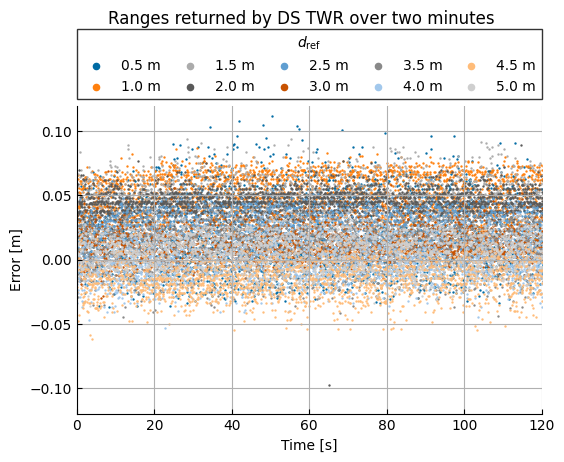

In [13]:
names = ['0.5 m', '1.0 m', '1.5 m', '2.0 m', '2.5 m', '3.0 m', '3.5 m', '4.0 m', '4.5 m', '5.0 m']

fig, ax = plt.subplots(figsize=(6, 4))

for i in range(log_num):
    ax.scatter( (np.array(ts[i])-ts[i][0])/1e6, (i+1)*0.5 - np.array(dist_meas[i])/1000, s=0.5, label = names[i])
ax.set_ylabel("Range [m]")
ax.set_ylabel("Error [m]")
ax.set_xlabel("Time [s]")
#ax.set_yticks([0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], minor=True)
ax.set_xlim([0,120])
ax.set_ylim([-0.12,0.12])
ax.grid(which='both')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(direction='in', which='both')
fig.suptitle('Ranges returned by DS TWR over two minutes', y=1.12)
#lgnd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=5, mode="expand", borderaxespad=0., scatterpoints=1, fancybox=False, edgecolor='black', title='Nodes participating in measurement')
lgnd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=5, mode="expand", borderaxespad=0., scatterpoints=1, fancybox=False, edgecolor='black', title='$d_\mathrm{ref}$')
for handle in lgnd.legend_handles:
    handle.set_sizes([20.0])
#plt.savefig("twr_time.pdf", format="pdf", bbox_inches="tight")

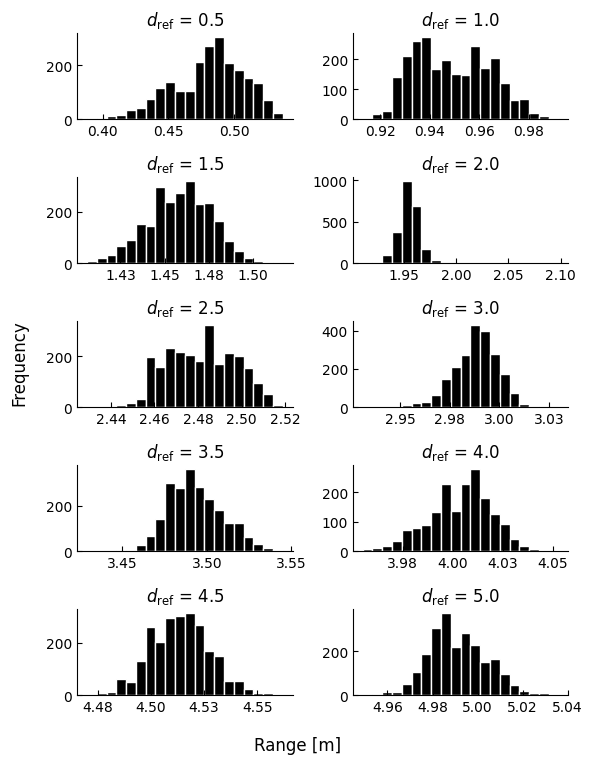

In [6]:
# Generate histograms
hist_data = [None]*log_num
for i in range(log_num):
    temp_data = np.array(dist_meas[i])/1000
    hist_data[i] = np.histogram(temp_data, bins=20)

fig, axs = plt.subplots(5, 2, figsize=(6, 8))

numbers = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

for i in range(log_num):
    ax = axs.flatten()[i]
    counts, bins = hist_data[i]
    ax.hist(bins[:-1], bins, weights=counts, facecolor='black', edgecolor='white')
    #ax.axvline(x=numbers[i], color='red', linestyle='--', linewidth=1)
    
    #start, end = ax.get_xlim()
    #ax.set_xticks(np.arange(np.floor(start * 20) / 20, np.ceil(end * 20) / 20 + 0.001, 0.05))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax.set_title('$d_\mathrm{ref}$ = ' + str(numbers[i]))
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(direction='in', which='both')

fig.supxlabel('Range [m]')
fig.supylabel('Frequency')
fig.tight_layout(rect=[0, 0, 1, 0.96])


In [14]:
# Statistics of errors
names = ['0.5m', '1m', '1.5m', '2m', '2.5m', '3m', '3.5m', '4m', '4.5m', '5m']

error_app = np.empty((0))

# Check the variation and mean
for i in range(log_num):
    temp_data = (i+1)*500 - np.array(dist_meas[i])
    error_app = np.append(error_app, temp_data)
    mean_dist = np.mean(temp_data/1000)
    var_dist = np.var(temp_data/1000)

    print("Statistics for distance: " + names[i])
    print("Mean: " + str(mean_dist) + ", std var: " + str(np.sqrt(var_dist)))

# Overall error
mean_app = np.mean(error_app/1000)
var_app = np.var(error_app/1000)
print("Overall statistics")
print("Mean: " + str(mean_app) + ", variance: " + str(var_app))



Statistics for distance: 0.5m
Mean: 0.019180410022779044, std var: 0.027220390970188548
Statistics for distance: 1m
Mean: 0.050857314148681054, std var: 0.015364347494159802
Statistics for distance: 1.5m
Mean: 0.04147383483237939, std var: 0.01786732041379238
Statistics for distance: 2m
Mean: 0.044723251895534964, std var: 0.00972059488021921
Statistics for distance: 2.5m
Mean: 0.018613506916192027, std var: 0.0156160298133671
Statistics for distance: 3m
Mean: 0.011503519474425154, std var: 0.011291885343675234
Statistics for distance: 3.5m
Mean: 0.0065053191489361705, std var: 0.016067509617973652
Statistics for distance: 4m
Mean: -0.0037142051860202933, std var: 0.015347057968601273
Statistics for distance: 4.5m
Mean: -0.01390813758389262, std var: 0.01378686154385373
Statistics for distance: 5m
Mean: 0.00877441962330267, std var: 0.012470356020750788
Overall statistics
Mean: 0.01939183440775337, variance: 0.0006776246090236689
